## Import Libraries

**Required packages**:
- `pandas`: DataFrame manipulation and data analysis
- `numpy`: Numerical operations and array handling
- `matplotlib`: Plotting and visualization
- `re`: Regular expressions for pattern matching
- `pathlib`: Modern file path handling

# MSPP Data Analysis Notebook

**Purpose**: Analyze mass spectrometry proteomics data from Orbitrap Astral MS (DIA-NN output)

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
from pathlib import Path

plt.style.use('dark_background')

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.width', None)

print("✓ Libraries imported successfully")
print(f"Pandas version: {pd.__version__}")
print(f"NumPy version: {np.__version__}")

✓ Libraries imported successfully
Pandas version: 2.3.3
NumPy version: 2.3.5


## File Upload

**Instructions**: 
1. Run the cell below to open a file browser
2. Select your E25 and E100 TSV files (hold Ctrl/Cmd to select multiple)
3. Files will be loaded into the notebook

**File Pattern**: `report.pg_matrix_E{25|100}_{4_params}.tsv`

In [11]:
from tkinter import Tk, filedialog

root = Tk()
root.withdraw()
root.attributes('-topmost', True)

print("Please select your TSV files (E25 and E100)...")
file_paths = filedialog.askopenfilenames(
    title='Select TSV Files',
    filetypes=[('TSV files', '*.tsv'), ('Text files', '*.txt'), ('All files', '*.*')]
)

if len(file_paths) < 2:
    raise ValueError("Please select at least 2 files (E25 and E100)")

e25_file_path = next((f for f in file_paths if 'E25' in f), None)
e100_file_path = next((f for f in file_paths if 'E100' in f), None)

if not e25_file_path or not e100_file_path:
    raise ValueError("Could not find E25 and E100 files. Make sure filenames contain 'E25' and 'E100'")

print(f"✓ E25 file: {Path(e25_file_path).name}")
print(f"✓ E100 file: {Path(e100_file_path).name}")

hela_pattern = r"sp\|"
ecoli_pattern = r"ECOLI"
yeast_pattern = r"YEAST"

Please select your TSV files (E25 and E100)...
✓ E25 file: report.pg_matrix_E25_30_4_440960_600.tsv
✓ E100 file: report.pg_matrix_E100_30_4_440960_600.tsv
✓ E25 file: report.pg_matrix_E25_30_4_440960_600.tsv
✓ E100 file: report.pg_matrix_E100_30_4_440960_600.tsv


## Organism Identification Function

**Purpose**: Vectorized function to identify protein organism using regex patterns

- Uses pandas string matching for efficiency
- Returns "HeLa", "E.coli", "Yeast", or "Unknown"
- Processes entire columns at once (not row-by-row)

In [12]:
def identify_organism(protein_ids, hela_pattern, ecoli_pattern, yeast_pattern):
    organism = pd.Series("Unknown", index=protein_ids.index)
    
    organism[protein_ids.str.contains(hela_pattern, na=False)] = "HeLa"
    organism[protein_ids.str.contains(ecoli_pattern, na=False)] = "E.coli"
    organism[protein_ids.str.contains(yeast_pattern, na=False)] = "Yeast"
    
    return organism

## Load and Process Data

**Steps**:
1. Load TSV files into DataFrames
2. Detect intensity columns (containing "E25" or "E100")
3. Create unified DataFrame with Sample column
4. Identify organism for each protein
5. Filter to keep only consensus proteins (valid in both E25 and E100)

In [13]:
def identify_organism_vectorized(protein_ids):
    organism = pd.Series("Unknown", index=protein_ids.index)
    organism[protein_ids.str.contains(hela_pattern, na=False)] = "HeLa"
    organism[protein_ids.str.contains(ecoli_pattern, na=False)] = "E.coli"
    organism[protein_ids.str.contains(yeast_pattern, na=False)] = "Yeast"
    return organism

all_data = []
for file_path in [e25_file_path, e100_file_path]:
    print(f"\nLoading: {Path(file_path).name}")
    df = pd.read_csv(file_path, sep="\t")
    
    intensity_cols = [col for col in df.columns if any(x in col for x in ["E25", "E100"])]
    print(f"  Intensity columns: {len(intensity_cols)}")
    
    df_long = df.melt(
        id_vars=[col for col in df.columns if col not in intensity_cols],
        value_vars=intensity_cols,
        var_name="Sample",
        value_name="Intensity"
    )
    
    df_long = df_long[df_long["Intensity"] > 0]
    df_long["Source_File"] = Path(file_path).stem
    
    protein_col = next(
        (col for col in ["Protein.Names", "Protein.Group"] if col in df.columns), 
        None
    ) or next((col for col in df.columns if "protein" in col.lower()), None)

    df_long["Organism"] = (
        identify_organism_vectorized(df_long[protein_col]) if protein_col else "Unknown"
    )
    
    print(f"  → Rows: {len(df_long):,}")
    all_data.append(df_long)

data = pd.concat(all_data, ignore_index=True)

print(f"\n✓ Data loaded successfully")
print(f"Total rows: {len(data):,}")
print(f"Total columns: {len(data.columns)}")
print(f"\nSource files: {sorted(data['Source_File'].unique())}")


Loading: report.pg_matrix_E25_30_4_440960_600.tsv
  Intensity columns: 0
  → Rows: 0

Loading: report.pg_matrix_E100_30_4_440960_600.tsv
  Intensity columns: 0
  → Rows: 0

✓ Data loaded successfully
Total rows: 0
Total columns: 12

Source files: []


## Data Overview

Quick look at the loaded data structure and organism distribution across samples.

In [ ]:
print("=" * 80)
print("DATA PREVIEW")
print("=" * 80)
print(f"\nFirst 5 rows:")
display(data.head())

print(f"\n{'=' * 80}")
print("ORGANISM DISTRIBUTION")
print("=" * 80)
organism_counts = data['Organism'].value_counts()
print(organism_counts)
print(f"\nTotal protein identifications: {organism_counts.sum():,}")

print(f"\n{'=' * 80}")
print("ORGANISM DISTRIBUTION BY SAMPLE")
print("=" * 80)
sample_org_counts = data.groupby(['Source_File', 'Organism']).size().unstack(fill_value=0)
display(sample_org_counts)

,Protein.Group,Protein.Names,Genes,First.Protein.Description,N.Sequences,N.Proteotypic.Sequences,D:\QC_DIA\57389.raw,Sample,Intensity,Source_File,Organism,D:\QC_DIA\57390.raw


## Helper Functions

Functions to extract mix identifiers and calculate intensity ratios.

In [17]:
def extract_mix_identifier(sample_name):
    match = re.search(r"_(\d+)_(\d+)_(\d+)_(\d+)", sample_name)
    return f"{match.group(1)}_{match.group(2)}_{match.group(3)}_{match.group(4)}" if match else "Unknown"

file_to_raw_column = {
    Path(e25_file_path).stem: next((col for col in pd.read_csv(e25_file_path, sep="\t", nrows=0).columns if "E25" in col), None),
    Path(e100_file_path).stem: next((col for col in pd.read_csv(e100_file_path, sep="\t", nrows=0).columns if "E100" in col), None)
}

## Intensity Ratio Calculation Function

**Purpose**: Calculate log2(E25/E100) intensity ratios for consensus proteins

**Algorithm**:
1. Find proteins with valid intensities in BOTH E25 and E100
2. For each consensus protein: calculate log2(E25_intensity / E100_intensity)
3. Return array of ratios (one per protein)

**Key Points**:
- No HeLa normalization (preserves technical variation)
- Each box plot shows distribution of hundreds/thousands of protein ratios
- Not a single median value per run

In [18]:
def calculate_intensity_ratios(data, e25_file, e100_file, organism, file_to_raw_column):
    if e25_file not in file_to_raw_column or e100_file not in file_to_raw_column:
        return None
    
    e25_intensity_col = file_to_raw_column[e25_file]
    e100_intensity_col = file_to_raw_column[e100_file]
    
    e25_data = data[data["Source_File"] == e25_file].copy()
    e100_data = data[data["Source_File"] == e100_file].copy()
    
    e25_org = e25_data[e25_data["Organism"] == organism]
    e100_org = e100_data[e100_data["Organism"] == organism]
    
    if len(e25_org) == 0 or len(e100_org) == 0:
        return None
    
    protein_col = next(
        (col for col in ["Protein.Group", "Protein.Ids", "Protein.Names"] if col in e25_org.columns),
        None
    )
    
    if protein_col is None:
        return None
    
    e25_valid = e25_org[
        (e25_org[e25_intensity_col].notna()) & 
        (e25_org[e25_intensity_col] > 0)
    ]
    e100_valid = e100_org[
        (e100_org[e100_intensity_col].notna()) & 
        (e100_org[e100_intensity_col] > 0)
    ]
    
    e25_proteins = set(e25_valid[protein_col])
    e100_proteins = set(e100_valid[protein_col])
    consensus_proteins = e25_proteins & e100_proteins
    
    print(f"  {organism}:")
    print(f"    E25 proteins: {len(e25_proteins)}")
    print(f"    E100 proteins: {len(e100_proteins)}")
    print(f"    Consensus proteins: {len(consensus_proteins)}")
    
    if len(consensus_proteins) == 0:
        return None
    
    e25_consensus = e25_valid[e25_valid[protein_col].isin(consensus_proteins)].set_index(protein_col)
    e100_consensus = e100_valid[e100_valid[protein_col].isin(consensus_proteins)].set_index(protein_col)
    
    common_proteins = e25_consensus.index.intersection(e100_consensus.index)
    
    e25_aligned = e25_consensus.loc[common_proteins, e25_intensity_col]
    e100_aligned = e100_consensus.loc[common_proteins, e100_intensity_col]
    
    ratios = np.log2(e25_aligned.values / e100_aligned.values)
    
    valid_ratios = ratios[np.isfinite(ratios)]
    
    if len(valid_ratios) > 0:
        print(f"    Median log2 ratio: {np.median(valid_ratios):.2f}")
    
    return valid_ratios if len(valid_ratios) > 0 else None

print("✓ Intensity ratio calculation function defined")

✓ Intensity ratio calculation function defined


## Calculate Intensity Ratios

Identify E25/E100 pairs and calculate log2 intensity ratios for each run and organism.

In [19]:
data["mix_id"] = data["Sample"].apply(extract_mix_identifier)

mix_groups = {}
for source_file in data["Source_File"].unique():
    for mix_id in data[data["Source_File"] == source_file]["mix_id"].unique():
        if mix_id not in mix_groups:
            mix_groups[mix_id] = {}
        mix_groups[mix_id][source_file] = True

print(f"Found {len(mix_groups)} unique mix(es)")
for mix_id in sorted(mix_groups.keys()):
    print(f"  {mix_id}: {list(mix_groups[mix_id].keys())}")

Found 0 unique mix(es)


In [20]:
ORGANISMS = ["HeLa", "E.coli", "Yeast"]
hela_results = []
ecoli_results = []
yeast_results = []

e25_stem = Path(e25_file_path).stem
e100_stem = Path(e100_file_path).stem

for mix_id in sorted(mix_groups.keys()):
    files = list(mix_groups[mix_id].keys())
    
    e25_file = next((f for f in files if "E25" in f), None)
    e100_file = next((f for f in files if "E100" in f), None)
    
    if not e25_file or not e100_file:
        continue
    
    print(f"\nProcessing mix {mix_id}:")
    print(f"  E25: {e25_file}")
    print(f"  E100: {e100_file}")
    
    for organism in ORGANISMS:
        ratios = calculate_intensity_ratios(data, e25_file, e100_file, organism, file_to_raw_column)
        
        if ratios is not None:
            if organism == "HeLa":
                hela_results.append((ratios, mix_id))
            elif organism == "E.coli":
                ecoli_results.append((ratios, mix_id))
            elif organism == "Yeast":
                yeast_results.append((ratios, mix_id))

sorted_mixes = sorted(mix_groups.keys())
print(f"\n✓ Calculated ratios for {len(sorted_mixes)} mix(es)")


✓ Calculated ratios for 0 mix(es)


## Protein Count Bar Chart

Stacked bar chart showing organism composition across samples.

<positron-console-cell-21>:39: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


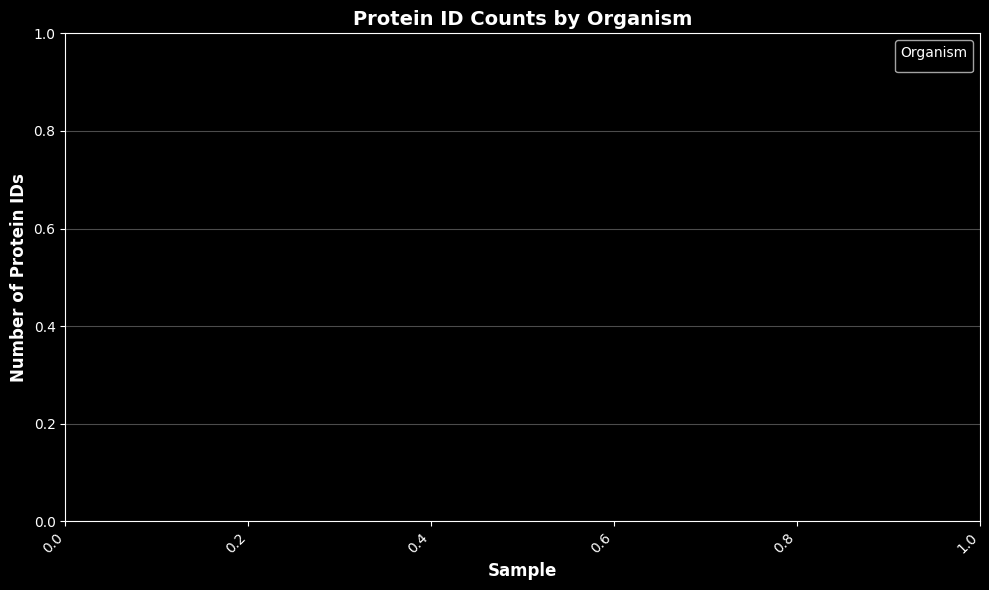

In [ ]:
ORGANISMS = ["HeLa", "E.coli", "Yeast"]
COLORS = {"HeLa": "#9b59b6", "E.coli": "#e67e22", "Yeast": "#16a085", "Unknown": "#95a5a6"}

counts = data.groupby(["Source_File", "Organism"]).size().unstack(fill_value=0)
org_order = ORGANISMS + ["Unknown"]
counts = counts.reindex(
    columns=[col for col in org_order if col in counts.columns], fill_value=0
)

print("Protein ID Counts by Sample:")
print(counts)
print()

fig, ax = plt.subplots(figsize=(12, 6))

bottom = np.zeros(len(counts))
for organism in counts.columns:
    ax.bar(
        range(len(counts)), counts[organism], bottom=bottom,
        label=organism, color=COLORS.get(organism, "#95a5a6"), alpha=0.8
    )
    bottom += counts[organism].values

for i, sample in enumerate(counts.index):
    y_offset = 0
    for organism in counts.columns:
        count = counts.loc[sample, organism]
        if count > 0:
            bar_height = count
            y_pos = y_offset + bar_height / 2
            
            ax.text(
                i, y_pos, str(int(count)),
                ha='center', va='center',
                fontsize=9, fontweight='bold',
                color='white'
            )
            y_offset += bar_height

ax.set_xlabel("Sample", fontsize=12, fontweight="bold")
ax.set_ylabel("Number of Protein IDs", fontsize=12, fontweight="bold")
ax.set_title("Protein ID Counts by Organism", fontsize=14, fontweight="bold")
ax.legend(title="Organism", fontsize=10, loc="upper right")
ax.grid(axis="y", alpha=0.3)
ax.set_xticks(range(len(counts)))
ax.set_xticklabels(counts.index, rotation=45, ha="right")
plt.tight_layout()
plt.show()

## Intensity Ratio Plots

**3-panel stacked plot showing log2 intensity ratios:**
- Top: HeLa (expected ratio = 0)
- Middle: E.coli (expected ratio = -2)
- Bottom: Yeast (expected ratio = +1)

**Note**: Each box shows distribution of protein ratios, not a single median.

In [23]:
def plot_ratio_comparison(ax, results, sorted_mixes, title, color, reference_line):
    data_arrays = [r[0] for r in results]
    mix_labels = [r[1] for r in results]
    positions = np.arange(1, len(data_arrays) + 1)
    
    bp = ax.boxplot(
        data_arrays,
        positions=positions,
        widths=0.6,
        patch_artist=True,
        showfliers=True,
        showmeans=True,
        flierprops=dict(
            marker="o", markerfacecolor=color, markersize=3,
            alpha=0.4, markeredgecolor="none"
        ),
        meanprops=dict(
            marker="s", markerfacecolor="white", 
            markeredgecolor="white", markersize=5
        ),
    )
    
    for patch in bp["boxes"]:
        patch.set_facecolor(color)
        patch.set_alpha(0.7)
        patch.set_edgecolor("white")
        patch.set_linewidth(1.5)
    
    plt.setp(bp["whiskers"], color="white", linewidth=1.5)
    plt.setp(bp["caps"], color="white", linewidth=1.5)
    plt.setp(bp["medians"], color="#2c3e50", linewidth=2.5)
    
    for i, data_arr in enumerate(data_arrays):
        median_val = np.median(data_arr)
        ax.text(
            i + 1, median_val, f"{median_val:.2f}",
            fontsize=9, va="bottom", ha="center", color="white", 
            fontweight="bold", 
            bbox=dict(boxstyle="round,pad=0.3", 
                     facecolor="black", alpha=0.5, edgecolor="none")
        )
    
    ax.axhline(y=reference_line, color="#f39c12", linestyle="--", 
               linewidth=2, alpha=0.9, 
               label=f"Expected: {reference_line}")
    
    ax.set_ylabel("Log2 Intensity Ratio", fontsize=11, fontweight="bold")
    ax.set_title(title, fontsize=12, fontweight="bold")
    ax.set_xticks(positions)
    ax.set_xticklabels(mix_labels, rotation=45, ha="right", fontsize=9)
    ax.grid(axis="y", alpha=0.3)
    ax.legend(fontsize=9, loc="upper right")

print("✓ Plotting function defined")

✓ Plotting function defined


In [ ]:
if hela_results or ecoli_results or yeast_results:
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(18, 16))
    
    if hela_results:
        plot_ratio_comparison(
            ax1, hela_results, sorted_mixes,
            title="HeLa Log2 Intensity Ratio",
            color="#9b59b6",
            reference_line=0
        )
    else:
        ax1.text(0.5, 0.5, "No HeLa data", ha="center", va="center",
                transform=ax1.transAxes, fontsize=14)
        ax1.set_ylabel("Log2 Intensity Ratio", fontsize=11, fontweight="bold")
        ax1.set_title("HeLa Log2 Intensity Ratio", fontsize=12, fontweight="bold")
    
    if ecoli_results:
        plot_ratio_comparison(
            ax2, ecoli_results, sorted_mixes,
            title="E.coli Log2 Intensity Ratio",
            color="#e67e22",
            reference_line=-2
        )
    else:
        ax2.text(0.5, 0.5, "No E.coli data", ha="center", va="center",
                transform=ax2.transAxes, fontsize=14)
        ax2.set_ylabel("Log2 Intensity Ratio", fontsize=11, fontweight="bold")
        ax2.set_title("E.coli Log2 Intensity Ratio", fontsize=12, fontweight="bold")
    
    if yeast_results:
        plot_ratio_comparison(
            ax3, yeast_results, sorted_mixes,
            title="Yeast Log2 Intensity Ratio",
            color="#16a085",
            reference_line=1
        )
    else:
        ax3.text(0.5, 0.5, "No Yeast data", ha="center", va="center",
                transform=ax3.transAxes, fontsize=14)
        ax3.set_ylabel("Log2 Intensity Ratio", fontsize=11, fontweight="bold")
        ax3.set_title("Yeast Log2 Intensity Ratio", fontsize=12, fontweight="bold")
    
    plt.suptitle(
        "Intensity Ratio Comparison by Run",
        fontsize=16,
        fontweight="bold",
        y=0.995
    )
    plt.tight_layout()
    plt.show()
    
    print("\n✓ Plots generated successfully")
else:
    print("⚠ No results to plot - check that your data contains valid E25/E100 pairs")

No results to plot


## Statistical Summaries

Calculate quartiles, medians, and other statistics for each organism.

In [25]:
if hela_results:
    print("HeLa Statistics:")
    print("=" * 60)
    for ratios, mix_id in hela_results:
        print(f"\n{mix_id}:")
        print(f"  Count: {len(ratios)}")
        print(f"  Median: {np.median(ratios):.3f}")
        print(f"  Mean: {np.mean(ratios):.3f}")
        print(f"  Std: {np.std(ratios):.3f}")
        print(f"  Q1: {np.percentile(ratios, 25):.3f}")
        print(f"  Q3: {np.percentile(ratios, 75):.3f}")
else:
    print("No HeLa results")

No HeLa results


In [26]:
if ecoli_results:
    print("E.coli Statistics:")
    print("=" * 60)
    for ratios, mix_id in ecoli_results:
        print(f"\n{mix_id}:")
        print(f"  Count: {len(ratios)}")
        print(f"  Median: {np.median(ratios):.3f}")
        print(f"  Mean: {np.mean(ratios):.3f}")
        print(f"  Std: {np.std(ratios):.3f}")
        print(f"  Q1: {np.percentile(ratios, 25):.3f}")
        print(f"  Q3: {np.percentile(ratios, 75):.3f}")
else:
    print("No E.coli results")

print("\n" + "=" * 60 + "\n")

if yeast_results:
    print("Yeast Statistics:")
    print("=" * 60)
    for ratios, mix_id in yeast_results:
        print(f"\n{mix_id}:")
        print(f"  Count: {len(ratios)}")
        print(f"  Median: {np.median(ratios):.3f}")
        print(f"  Mean: {np.mean(ratios):.3f}")
        print(f"  Std: {np.std(ratios):.3f}")
        print(f"  Q1: {np.percentile(ratios, 25):.3f}")
        print(f"  Q3: {np.percentile(ratios, 75):.3f}")
else:
    print("No Yeast results")

No E.coli results


No Yeast results


## Validation

**Expected Patterns**:
- HeLa: ~0 (constant concentration)
- E.coli: ~-2 (log2(25/100))
- Yeast: ~+1 (log2(150/75))

**Pass Criteria**:
- HeLa: median within ±0.5 of 0
- E.coli: median between -2.5 and -1.5
- Yeast: median between 0.5 and 1.5

In [27]:
print("Validation Summary:")
print("=" * 60)

if hela_results:
    hela_medians = [np.median(r[0]) for r in hela_results]
    
    print("\nHeLa Expected Pattern:")
    print(f"  Median range: {min(hela_medians):.2f} to {max(hela_medians):.2f}")
    print(f"  Average median: {np.mean(hela_medians):.2f}")
    print(f"  Expected: ~0 (constant concentration)")
    print(f"  Status: {'✓ PASS' if abs(np.mean(hela_medians)) < 0.5 else '⚠ CHECK'}")

if ecoli_results:
    ecoli_medians = [np.median(r[0]) for r in ecoli_results]
    
    print("\nE.coli Expected Pattern:")
    print(f"  Median range: {min(ecoli_medians):.2f} to {max(ecoli_medians):.2f}")
    print(f"  Average median: {np.mean(ecoli_medians):.2f}")
    print(f"  Expected: ~-2 (log2(25/100) = -2)")
    print(f"  Status: {'✓ PASS' if -2.5 < np.mean(ecoli_medians) < -1.5 else '⚠ CHECK'}")

if yeast_results:
    yeast_medians = [np.median(r[0]) for r in yeast_results]
    
    print("\nYeast Expected Pattern:")
    print(f"  Median range: {min(yeast_medians):.2f} to {max(yeast_medians):.2f}")
    print(f"  Average median: {np.mean(yeast_medians):.2f}")
    print(f"  Expected: ~+1 (log2(150/75) = 1)")
    print(f"  Status: {'✓ PASS' if 0.5 < np.mean(yeast_medians) < 1.5 else '⚠ CHECK'}")

print("\n✓ Analysis complete!")

Validation Summary:

✓ Analysis complete!


## Notes

### Expected Results
- **HeLa**: log2 ratio ~0 (constant concentration, identical between E25 and E100)
- **E.coli**: log2 ratio ~-2 (25 fmol vs 100 fmol → log2(25/100) = -2)
- **Yeast**: log2 ratio ~+1 (150 fmol vs 75 fmol → log2(150/75) = 1)

### Intensity Ratio Algorithm
The intensity ratio approach provides:
1. **Direct comparison** of E25 vs E100 replicates without normalization
2. **Technical variation assessment** - raw ratios preserve variability for QC
3. **Consensus proteins** - only proteins with valid intensity in BOTH samples
4. **Paired calculation** - log2(E25_intensity / E100_intensity) per protein

### Interpretation
- **HeLa ratios near 0**: Good technical reproducibility
- **E.coli ratios near -2**: Correct 4-fold spike-in maintained
- **Yeast ratios near +1**: Correct 2-fold spike-in maintained
- **Deviations from expected**: Indicate technical issues or sample preparation problems

### Workflow
- **Jupyter Notebook**: Development, validation, detailed analysis, QC checks
- **Web App**: Production tool for routine analysis with simplified interface

### Next Steps
- Use this notebook to validate new data files
- Check for outliers or unexpected patterns
- Export results for reporting
- Port new features to web app after validation